In [1]:
from optimization.acs import ACS_VRP,ACS_TSP
from optimization.bso import BSO_VRP,BSO_TSP
from optimization.ga import GA_VRP
from optimization.sa import SA_VRP
from optimization.tabu_search import TS_VRP
from optimization.dka import DKA_VRP

from optimization.other.algorithm_woa import WOA_VRP

from optimization.aco import ACO_VRP,ACO_TSP
from optimization.haco import HACO_VRP,HACO_TSP

from optimization.koneksi import ConDB

import sql_connection
import json
import time
import random
import datetime
import copy
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import FancyArrowPatch

import warnings
warnings.filterwarnings('ignore')

# Generate Data

In [2]:
def generate_data(n = 30, random_state = None):
    random.seed(random_state)
    query = """SELECT 
                    p.post_id,
                    p.post_type,
                    CASE
                        WHEN pj.pj_jam_buka = pj.pj_jam_tutup THEN "tutup"
                        ELSE "buka"
                    END AS is_operate
                FROM 
                    posts p
                LEFT JOIN
                    posts_jadwal pj
                    ON p.post_id = pj.pj_id_tempat AND pj.pj_hari = "minggu"
                """
    
    db_name = 'rekomendasi_wisata_2'
    df_location = sql_connection.read_from_sql(query,db=db_name)
    
    tourid = df_location[(df_location['post_type']=="location")&
                         (df_location['is_operate'] != "tutup")]['post_id'].values.tolist()

    tourid = random.sample(tourid,n)
    idhotel = df_location[df_location['post_type']=="hotel"]['post_id'].values.tolist()
    idhotel = idhotel[random.randint(0,len(idhotel)-1)]
    
    db = ConDB()

    hotel = db.HotelbyID(idhotel,db=db_name)
    tur = db.WisatabyID(tourid,db=db_name)
    timematrix = db.TimeMatrixbyID_bdg(hotel._id,tourid)
    
    return hotel,tur,timematrix#,tourid,idhotel

# Analisis


In [3]:
def find_node(node_id,tour):
    for node in tour:
        if node._id == node_id:
            return node
    return False

def time_to_second(time):
    return (time.hour*3600)+(time.minute*60)+time.second

def diff_second_between_time(time_a,time_b):
    #input: time_a and time_b, datetime.time()
    #output: time_b - time_a, seconds (int)
    return time_to_second(time_b) - time_to_second(time_a)

def get_attribute_analysis(solution):
    days_needed = len(solution)
    poi_included = len(sum([sol["index"] for sol in solution],[]))
    avg_rating = sum(sum([sol["rating"] for sol in solution],[]))/poi_included
    total_tarif = sum(sum([sol["tarif"] for sol in solution],[]))
    total_duration = sum([diff_second_between_time(j[0],j[-1]) for j in [i['waktu'] for i in solution]])
    return days_needed,poi_included,avg_rating,total_tarif,total_duration

def get_analysis(model,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating):
    start = time.time()
    model.set_model(tour=tur,hotel=hotel,timematrix=timematrix,
                    travel_days=travel_days,
                    degree_waktu = dwaktu,degree_tarif = dtarif,degree_rating = drating)
    solution,fitness = model.construct_solution()[-2:]
    end = time.time()
    run_time = end-start
    
    daily_fitness = []
    for day in solution:
        daily_fitness.append(model.MAUT([day],use_penalty=False))
    days_needed,poi_included,avg_rating,total_tarif,total_duration = get_attribute_analysis(solution)
    results = {"solution":[sol["index"] for sol in solution],
               "fitness":fitness,
               "daily_fitness":daily_fitness,
               "days_needed":days_needed,
               "poi_included":poi_included,
               "avg_rating":avg_rating,
               "total_tarif":total_tarif,
               "total_duration":total_duration,
               "run_time":run_time}
    
    return results

In [4]:
def get_detail_node_on_solution(solution,db_name = "rekomendasi_wisata_2"):
    db = ConDB()
    node_solution = []
    for i in solution:
        nodes = db.WisatabyID(i,db=db_name)
        node_solution.append(nodes)
    return node_solution

def visualize_solution(solution_node,hotel):
    # Sample VRP data
    vrp_data = [[hotel]+sol+[hotel] for sol in solution_node]
    
    # Generate random node coordinates
    node_coords = {node._id: (float(node.long), float(node.lat)) for node in set(node for route in vrp_data for node in route)}  

    # Number of routes (you can calculate this)
    num_routes = len(vrp_data)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12,9))

    # Define the colors for routes using a colormap
    cmap = plt.get_cmap('tab20', num_routes)

    for i, route in enumerate(vrp_data):
        x = [node_coords[node._id][0] for node in route]
        y = [node_coords[node._id][1] for node in route]
        color = cmap(i)  # Get the color for the route
        # Plot the nodes (scatter plot)
        ax.scatter(x, y, c=color, label=f'Route {i + 1}', s=100)

        for j in range(len(x) - 1):
            # Make the arrow heads larger by increasing mutation_scale
            arrow = FancyArrowPatch(
                (x[j], y[j]), (x[j + 1], y[j + 1]),
                arrowstyle='->', mutation_scale=15, color=color
            )
            ax.add_patch(arrow)

    # Set node 159 (start and end point) to black
    start_x, start_y = node_coords[hotel._id]
    ax.scatter(start_x, start_y, c='k', label='Hotel', s=100)

    # Add labels for nodes
    for node, (x, y) in node_coords.items():
        ax.annotate(str(node), (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

    # Add legend
    ax.legend()

    plt.show()



## Hyperparameter tuning

### Iteration convergence

In [5]:
iteration_convergence_analysis ={
    "1,1,1": [],
    "1,0,0": [],
    "0,1,0": [],
    "0,0,1": [],
}

doi_combi = [(1,1,1),(1,0,0),(0,1,0),(0,0,1)]

for doi in doi_combi:
    hotel,tur,timematrix = generate_data(n=30,random_state=40)
    travel_days = 3
    dwaktu,dtarif,drating = doi
    
    # test hyperparameter max_iter : 
    dka_vrp = DKA_VRP(random_state=100,return_fitness_history=True)
    dka_vrp.set_model(tour=tur,hotel=hotel,timematrix=timematrix,
                    travel_days=travel_days,
                    degree_waktu = dwaktu,degree_tarif = dtarif,degree_rating = drating)
    solution,fitness,fitness_history = dka_vrp.construct_solution()
    
    iteration_convergence_analysis[",".join([str(i) for i in doi])] = fitness_history

In [6]:
iteration_convergence_analysis

{'1,1,1': [0.5967983728736419,
  0.5967983728736419,
  0.5985987843962753,
  0.5985987843962753,
  0.5985987843962753,
  0.5985987843962753,
  0.5985987843962753,
  0.5985987843962753,
  0.5985987843962753,
  0.5985987843962753,
  0.5985987843962753,
  0.6000769945572814,
  0.6077828981054787,
  0.6077828981054787,
  0.6077828981054787,
  0.6077828981054787,
  0.6077828981054787,
  0.6077828981054787,
  0.6077828981054787,
  0.6077828981054787,
  0.6077828981054787,
  0.6077828981054787,
  0.6077828981054787,
  0.6104948938954318,
  0.612501066734938,
  0.612501066734938,
  0.612501066734938,
  0.6135813136485179,
  0.6135813136485179,
  0.6135813136485179,
  0.6135813136485179,
  0.6135813136485179,
  0.6135813136485179,
  0.6135813136485179,
  0.6135813136485179,
  0.6197314392430879,
  0.6197314392430879,
  0.6197314392430879,
  0.6197314392430879,
  0.6197314392430879,
  0.6197314392430879,
  0.6197314392430879,
  0.6197314392430879,
  0.6197314392430879,
  0.6199629207245694,
  0.

In [7]:
result_df = pd.DataFrame()
for i in iteration_convergence_analysis:
    temp_df = pd.DataFrame({'best_fitness':iteration_convergence_analysis[i]})
    temp_df['doi_combi'] = i
    temp_df = temp_df.reset_index()
    temp_df = temp_df.rename(columns={'index':'iter'})
    temp_df['iter'] = temp_df['iter']+1
    result_df = pd.concat([result_df,temp_df]) 

In [8]:
result_df

,iter,best_fitness,doi_combi
0,1,0.596798,"1,1,1"
1,2,0.596798,"1,1,1"
2,3,0.598599,"1,1,1"
3,4,0.598599,"1,1,1"
4,5,0.598599,"1,1,1"
...,...,...,...
104,105,0.786639,"0,0,1"
105,106,0.786639,"0,0,1"
106,107,0.786639,"0,0,1"
107,108,0.786639,"0,0,1"


In [9]:
result_df.to_excel("dka_iteration_convergence.xlsx",index=False)

### Tuning for hyperparameters

In [12]:
hotel,tur,timematrix = generate_data(n=30,random_state=40)
travel_days = 3
dwaktu,dtarif,drating = 1,1,1

#### Hyperparameter : n

In [6]:
# n
n_ls = [5,10,15,20]
n_results = []
for n in n_ls:
    print(n)
    dka_vrp = DKA_VRP(n=n,random_state=100)
    results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    n_results.append([results_dka_vrp['fitness'],results_dka_vrp['run_time']])

5
10
15
20


In [21]:
n_results

[[0.6434002510167384, 2.2668440341949463],
 [0.6666653680328295, 6.990387439727783],
 [0.6646505376344088, 17.57559585571289],
 [0.6738713297853086, 60.89896059036255]]

In [24]:
result = {"n":n_ls,
          "fitness":[i[0] for i in n_results],
          "run_time":[i[1] for i in n_results]}
result = pd.DataFrame(result)
result.to_excel("dka_tuning_n_parameter.xlsx",index=False)

#### Hyperparameter : p

In [19]:
# p
p_ls = [0.25,0.5,0.75]
p_results = []
for p in p_ls:
    print(p)
    dka_vrp = DKA_VRP(p=p,random_state=100)
    results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    p_results.append([results_dka_vrp['fitness'],results_dka_vrp['run_time']])

0.25
0.5
0.75


In [20]:
p_results

[[0.6434002510167384, 2.1020259857177734],
 [0.6434002510167384, 2.304880142211914],
 [0.6390237500452555, 1.3925681114196777]]

#### Hyperparameter : smep

In [23]:
# smep
smep_ls = [3,5,8]
smep_results = []
for smep in smep_ls:
    print(smep)
    dka_vrp = DKA_VRP(p = 0.25,smep=smep,random_state=100)
    results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    smep_results.append([results_dka_vrp['fitness'],results_dka_vrp['run_time']])

3
5
8


In [24]:
smep_results

[[0.6557834166033091, 2.144763708114624],
 [0.6434002510167384, 2.234604597091675],
 [0.6642810271170486, 1.7997057437896729]]

## Outlier Sensitivity

In [10]:
outlier = pd.read_csv('Hasil Clustering Eps 1500.csv')
outlier.head()

,Unnamed: 0,id,name,type,latitude,longitude,tarif,durasi,rating,dbscan_cluster_relaxed1500,is_outlier
0,0,1,MALIOBORO JOGJAKARTA,location,-7.792576,110.365843,0,5400,4.8,0,False
1,1,2,Tourism Zone Malioboro,location,-7.798249,110.365279,0,3600,4.7,0,False
2,2,3,Plengkung Gading,location,-7.813728,110.362907,0,1800,4.6,0,False
3,3,4,Bringin Kembar Yogyakarta,location,-7.811936,110.363194,0,5400,4.6,0,False
4,4,5,Rumah Hantu Malioboro,location,-7.795638,110.365354,35000,2700,4.5,0,False


In [11]:
id_outlier = outlier[outlier['is_outlier']==True]['id'].values

In [12]:
id_outlier

array([39, 58, 62, 64, 65], dtype=int64)

In [13]:
hotel,tur,timematrix = generate_data(n=87,random_state=40)
dwaktu,dtarif,drating = 1,0,0

In [32]:
num_outlier = 0
travel_days = 0

outlier_sensitivity_analysis = {}
while num_outlier < len(id_outlier):
    travel_days += 1
    dka_vrp = DKA_VRP(random_state=100)
    results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    solution_ls = sum(results_dka_vrp['solution'],[])
    num_outlier = len([outlier for outlier in id_outlier if outlier in solution_ls])
    
    outlier_sensitivity_analysis[travel_days] = {"dka_vrp":num_outlier}

In [37]:
outlier_sensitivity_analysis

In [8]:
outlier_sensitivity_analysis = {1: {'dka_vrp': 0},
 2: {'dka_vrp': 0},
 3: {'dka_vrp': 0},
 4: {'dka_vrp': 0},
 5: {'dka_vrp': 0},
 6: {'dka_vrp': 1},
 7: {'dka_vrp': 3},
 8: {'dka_vrp': 2},
 9: {'dka_vrp': 3},
 10: {'dka_vrp': 2},
 11: {'dka_vrp': 4},
 12: {'dka_vrp': 4},
 13: {'dka_vrp': 5}}

In [16]:
min_days = 1
max_days = 13

In [14]:
for n_days in outlier_sensitivity_analysis:
    travel_days = n_days
    
    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    num_outlier = len([outlier for outlier in id_outlier if outlier in sum(results_acs_vrp['solution'],[])])
    outlier_sensitivity_analysis[travel_days]["acs_vrp"] = num_outlier
    
    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    num_outlier = len([outlier for outlier in id_outlier if outlier in sum(results_aco_vrp['solution'],[])])
    outlier_sensitivity_analysis[travel_days]["aco_vrp"] = num_outlier
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    num_outlier = len([outlier for outlier in id_outlier if outlier in sum(results_bso_vrp['solution'],[])])
    outlier_sensitivity_analysis[travel_days]["bso_vrp"] = num_outlier
    
    ga_vrp = GA_VRP(random_state=100)
    results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    num_outlier = len([outlier for outlier in id_outlier if outlier in sum(results_ga_vrp['solution'],[])])
    outlier_sensitivity_analysis[travel_days]["ga_vrp"] = num_outlier
    
    ts_vrp = TS_VRP(random_state=100)
    results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    num_outlier = len([outlier for outlier in id_outlier if outlier in sum(results_ts_vrp['solution'],[])])
    outlier_sensitivity_analysis[travel_days]["ts_vrp"] = num_outlier
    
    sa_vrp = SA_VRP(random_state=100)
    results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    num_outlier = len([outlier for outlier in id_outlier if outlier in sum(results_sa_vrp['solution'],[])])
    outlier_sensitivity_analysis[travel_days]["sa_vrp"] = num_outlier

In [15]:
outlier_sensitivity_analysis

{1: {'dka_vrp': 0,
  'acs_vrp': 0,
  'aco_vrp': 0,
  'bso_vrp': 0,
  'ga_vrp': 0,
  'ts_vrp': 0,
  'sa_vrp': 0},
 2: {'dka_vrp': 0,
  'acs_vrp': 0,
  'aco_vrp': 0,
  'bso_vrp': 0,
  'ga_vrp': 0,
  'ts_vrp': 0,
  'sa_vrp': 0},
 3: {'dka_vrp': 0,
  'acs_vrp': 0,
  'aco_vrp': 2,
  'bso_vrp': 0,
  'ga_vrp': 0,
  'ts_vrp': 0,
  'sa_vrp': 0},
 4: {'dka_vrp': 0,
  'acs_vrp': 0,
  'aco_vrp': 0,
  'bso_vrp': 0,
  'ga_vrp': 0,
  'ts_vrp': 0,
  'sa_vrp': 0},
 5: {'dka_vrp': 0,
  'acs_vrp': 0,
  'aco_vrp': 0,
  'bso_vrp': 0,
  'ga_vrp': 1,
  'ts_vrp': 0,
  'sa_vrp': 0},
 6: {'dka_vrp': 1,
  'acs_vrp': 0,
  'aco_vrp': 0,
  'bso_vrp': 0,
  'ga_vrp': 2,
  'ts_vrp': 0,
  'sa_vrp': 1},
 7: {'dka_vrp': 3,
  'acs_vrp': 2,
  'aco_vrp': 0,
  'bso_vrp': 3,
  'ga_vrp': 3,
  'ts_vrp': 0,
  'sa_vrp': 1},
 8: {'dka_vrp': 2,
  'acs_vrp': 0,
  'aco_vrp': 0,
  'bso_vrp': 3,
  'ga_vrp': 1,
  'ts_vrp': 0,
  'sa_vrp': 3},
 9: {'dka_vrp': 3,
  'acs_vrp': 3,
  'aco_vrp': 2,
  'bso_vrp': 3,
  'ga_vrp': 2,
  'ts_vrp': 0,

In [17]:
result = pd.DataFrame()
for i in outlier_sensitivity_analysis:
    if i not in range(min_days,max_days+1):
        continue
    else:
        travel_days = i
        methods = []
        num_outlier = []
        for j in outlier_sensitivity_analysis[i]:
            methods.append(j)
            num_outlier.append(outlier_sensitivity_analysis[i][j])
        temp_res = pd.DataFrame({'methods':methods,
                                'num_outlier':num_outlier})
        temp_res['travel_days'] = travel_days
        result = pd.concat([result,temp_res])

In [18]:
result

,methods,num_outlier,travel_days
0,dka_vrp,0,1
1,acs_vrp,0,1
2,aco_vrp,0,1
3,bso_vrp,0,1
4,ga_vrp,0,1
...,...,...,...
2,aco_vrp,5,13
3,bso_vrp,4,13
4,ga_vrp,5,13
5,ts_vrp,5,13


In [19]:
result.to_excel('dka_outlier_sensitivity.xlsx',index=False)

## General Performance (50 random nodes)

In [11]:
def result_to_xlsx_rd_nodes(result,random_ls,filename):
    df = pd.DataFrame()
    for method in result:
        res_method = result[method]
        df_method = {
            "random_seed" : random_ls,
            "fitness" : [],
            "fitness_1" : [],
            "fitness_2" : [],
            "fitness_3" : [],
            "poi_included" : [],
            "rating" : [],
            "tarif" : [],
            "total_duration" : [],
            "run_time" : [],
        }
        for res in res_method:
            df_method["fitness"].append(res['fitness'])
            df_method["fitness_1"].append(res['daily_fitness'][0])
            df_method["fitness_2"].append(res['daily_fitness'][1])
            df_method["fitness_3"].append(res['daily_fitness'][2])
            df_method["poi_included"].append(res['poi_included'])
            df_method["rating"].append(res['avg_rating'])
            df_method["tarif"].append(res['total_tarif'])
            df_method["total_duration"].append(res['total_duration'])
            df_method["run_time"].append(res['run_time'])
        df_method = pd.DataFrame(df_method)
        df_method['method'] = method
        df = pd.concat([df,df_method])
    df.to_excel(filename,index=False)

### All DOI 1

In [8]:
random_ls = list(range(5,(5*50)+1,5))
random_node_analysis ={
    "acs_vrp": [],
    "aco_vrp": [],
    "bso_vrp": [],
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
    "dka_vrp": [],
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,1,1
    
    print("random state = ",random_ls[i])
    
    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acs_vrp"].append(results_acs_vrp)
    
    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["aco_vrp"].append(results_aco_vrp)
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["bso_vrp"].append(results_bso_vrp)
    
    ga_vrp = GA_VRP(random_state=100)
    results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ga_vrp"].append(results_ga_vrp)

    ts_vrp = TS_VRP(random_state=100)
    results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ts_vrp"].append(results_ts_vrp)

    sa_vrp = SA_VRP(random_state=100)
    results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["sa_vrp"].append(results_sa_vrp)
    
    dka_vrp = DKA_VRP(random_state=100)
    results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["dka_vrp"].append(results_dka_vrp)

random state =  5
random state =  10
random state =  15
random state =  20
random state =  25
random state =  30
random state =  35
random state =  40
random state =  45
random state =  50
random state =  55
random state =  60
random state =  65
random state =  70
random state =  75
random state =  80
random state =  85
random state =  90
random state =  95
random state =  100
random state =  105
random state =  110
random state =  115
random state =  120
random state =  125
random state =  130
random state =  135
random state =  140
random state =  145
random state =  150
random state =  155
random state =  160
random state =  165
random state =  170
random state =  175
random state =  180
random state =  185
random state =  190
random state =  195
random state =  200
random state =  205
random state =  210
random state =  215
random state =  220
random state =  225
random state =  230
random state =  235
random state =  240
random state =  245
random state =  250


In [9]:
random_node_analysis

{'acs_vrp': [{'solution': [[34, 66, 2, 50, 7, 52, 4, 9, 15, 10],
    [55, 65, 93, 22, 35],
    [90, 14, 26, 51, 74, 88]],
   'fitness': 0.6814583957272639,
   'daily_fitness': [0.7093750000000002,
    0.6255612334032145,
    0.6508756988120196],
   'days_needed': 3,
   'poi_included': 21,
   'avg_rating': 4.614285714285715,
   'total_tarif': 37000,
   'total_duration': 125100,
   'run_time': 4.7696614265441895},
  {'solution': [[39, 74, 89, 10, 22, 36, 21, 32],
    [34, 51, 66, 18, 2, 57],
    [12, 6, 44, 71, 49, 46]],
   'fitness': 0.6441722659237409,
   'daily_fitness': [0.6318430432645035,
    0.6022748688954441,
    0.6027654867256638],
   'days_needed': 3,
   'poi_included': 20,
   'avg_rating': 4.58,
   'total_tarif': 24500,
   'total_duration': 124620,
   'run_time': 3.170985221862793},
  {'solution': [[46, 2, 33, 74, 53, 32, 22],
    [81, 68, 8, 20, 85, 57, 36, 3, 15, 50],
    [39, 71, 93, 43]],
   'fitness': 0.6119772106974622,
   'daily_fitness': [0.6038376050080051,
    0.57

In [12]:
result_to_xlsx_rd_nodes(random_node_analysis,random_ls,"dka_random_nodes_alldoi_1.xlsx")

### Travel Duration 1, other 0

In [13]:
random_ls = list(range(5,(5*50)+1,5))
random_node_analysis ={
    "acs_vrp": [],
    "aco_vrp": [],
    "bso_vrp": [],
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
    "dka_vrp": [],
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 1,0,0
    
    print("random state = ",random_ls[i])
    
    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acs_vrp"].append(results_acs_vrp)
    
    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["aco_vrp"].append(results_aco_vrp)
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["bso_vrp"].append(results_bso_vrp)
    
    ga_vrp = GA_VRP(random_state=100)
    results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ga_vrp"].append(results_ga_vrp)

    ts_vrp = TS_VRP(random_state=100)
    results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ts_vrp"].append(results_ts_vrp)

    sa_vrp = SA_VRP(random_state=100)
    results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["sa_vrp"].append(results_sa_vrp)
    
    dka_vrp = DKA_VRP(random_state=100)
    results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["dka_vrp"].append(results_dka_vrp)

random state =  5
random state =  10
random state =  15
random state =  20
random state =  25
random state =  30
random state =  35
random state =  40
random state =  45
random state =  50
random state =  55
random state =  60
random state =  65
random state =  70
random state =  75
random state =  80
random state =  85
random state =  90
random state =  95
random state =  100
random state =  105
random state =  110
random state =  115
random state =  120
random state =  125
random state =  130
random state =  135
random state =  140
random state =  145
random state =  150
random state =  155
random state =  160
random state =  165
random state =  170
random state =  175
random state =  180
random state =  185
random state =  190
random state =  195
random state =  200
random state =  205
random state =  210
random state =  215
random state =  220
random state =  225
random state =  230
random state =  235
random state =  240
random state =  245
random state =  250


In [14]:
random_node_analysis

{'acs_vrp': [{'solution': [[55, 2, 7, 15, 52, 88, 35, 66, 83, 9],
    [51, 34, 30, 26, 74],
    [90, 99, 50, 14, 48, 22, 10, 4]],
   'fitness': 0.6480324074074074,
   'daily_fitness': [0.5108796296296296,
    0.42407407407407405,
    0.47777777777777775],
   'days_needed': 3,
   'poi_included': 23,
   'avg_rating': 4.556521739130434,
   'total_tarif': 104500,
   'total_duration': 121980,
   'run_time': 3.0116777420043945},
  {'solution': [[97, 67, 18, 32, 10, 89, 36, 21, 49],
    [6, 12, 66, 57, 74, 5, 46, 2],
    [80, 22, 99, 44, 48, 71]],
   'fitness': 0.6423611111111112,
   'daily_fitness': [0.48796296296296293,
    0.4726851851851852,
    0.44074074074074077],
   'days_needed': 3,
   'poi_included': 23,
   'avg_rating': 4.534782608695653,
   'total_tarif': 196000,
   'total_duration': 124920,
   'run_time': 4.785303354263306},
  {'solution': [[42, 33, 50, 36, 15, 3, 85, 53, 2],
    [46, 57, 74, 99, 20, 93, 43],
    [47, 8, 81, 48, 32, 5, 22]],
   'fitness': 0.6312114197530865,
   '

In [15]:
result_to_xlsx_rd_nodes(random_node_analysis,random_ls,"dka_random_nodes_dwaktu_1.xlsx")

### Tarif 1, other 0

In [16]:
random_ls = list(range(5,(5*50)+1,5))
random_node_analysis ={
    "acs_vrp": [],
    "aco_vrp": [],
    "bso_vrp": [],
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
    "dka_vrp": [],
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 0,1,0
    
    print("random state = ",random_ls[i])
    
    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acs_vrp"].append(results_acs_vrp)
    
    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["aco_vrp"].append(results_aco_vrp)
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["bso_vrp"].append(results_bso_vrp)
    
    ga_vrp = GA_VRP(random_state=100)
    results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ga_vrp"].append(results_ga_vrp)

    ts_vrp = TS_VRP(random_state=100)
    results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ts_vrp"].append(results_ts_vrp)

    sa_vrp = SA_VRP(random_state=100)
    results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["sa_vrp"].append(results_sa_vrp)
    
    dka_vrp = DKA_VRP(random_state=100)
    results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["dka_vrp"].append(results_dka_vrp)

random state =  5
random state =  10
random state =  15
random state =  20
random state =  25
random state =  30
random state =  35
random state =  40
random state =  45
random state =  50
random state =  55
random state =  60
random state =  65
random state =  70
random state =  75
random state =  80
random state =  85
random state =  90
random state =  95
random state =  100
random state =  105
random state =  110
random state =  115
random state =  120
random state =  125
random state =  130
random state =  135
random state =  140
random state =  145
random state =  150
random state =  155
random state =  160
random state =  165
random state =  170
random state =  175
random state =  180
random state =  185
random state =  190
random state =  195
random state =  200
random state =  205
random state =  210
random state =  215
random state =  220
random state =  225
random state =  230
random state =  235
random state =  240
random state =  245
random state =  250


In [17]:
random_node_analysis

{'acs_vrp': [{'solution': [[34, 93, 4, 35, 10, 50, 9],
    [2, 14, 38, 55, 88, 7, 26],
    [51, 66, 99, 74, 22, 15, 52]],
   'fitness': 0.8094339622641509,
   'daily_fitness': [0.5930817610062893,
    0.5921383647798742,
    0.5836477987421383],
   'days_needed': 3,
   'poi_included': 21,
   'avg_rating': 4.604761904761904,
   'total_tarif': 43000,
   'total_duration': 128340,
   'run_time': 1.987593173980713},
  {'solution': [[38, 34, 39, 22, 57, 10],
    [44, 32, 46, 18, 71, 49, 66],
    [6, 89, 36, 21, 74, 51, 2]],
   'fitness': 0.8072271386430678,
   'daily_fitness': [0.5752212389380531,
    0.6078171091445428,
    0.5980825958702065],
   'days_needed': 3,
   'poi_included': 20,
   'avg_rating': 4.5649999999999995,
   'total_tarif': 29500,
   'total_duration': 127380,
   'run_time': 4.700382471084595},
  {'solution': [[57, 46, 22, 50, 71, 85, 3, 36, 15],
    [38, 20, 8, 93, 43],
    [32, 74, 2, 68, 81, 53, 33]],
   'fitness': 0.791200215920603,
   'daily_fitness': [0.62218358831710

In [18]:
result_to_xlsx_rd_nodes(random_node_analysis,random_ls,"dka_random_nodes_dtarif_1.xlsx")

### Rating 1, other 0

In [19]:
random_ls = list(range(5,(5*50)+1,5))
random_node_analysis ={
    "acs_vrp": [],
    "aco_vrp": [],
    "bso_vrp": [],
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
    "dka_vrp": [],
}
for i in range(len(random_ls)):
    # setting
    hotel,tur,timematrix = generate_data(n=30,random_state=random_ls[i]) #random state 50 blacklist
    travel_days = 3
    dwaktu,dtarif,drating = 0,0,1
    
    print("random state = ",random_ls[i])
    
    acs_vrp = ACS_VRP(random_state=100)
    results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["acs_vrp"].append(results_acs_vrp)
    
    aco_vrp = ACO_VRP(random_state=100)
    results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["aco_vrp"].append(results_aco_vrp)
    
    bso_vrp = BSO_VRP(random_state=100)
    results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["bso_vrp"].append(results_bso_vrp)
    
    ga_vrp = GA_VRP(random_state=100)
    results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ga_vrp"].append(results_ga_vrp)

    ts_vrp = TS_VRP(random_state=100)
    results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["ts_vrp"].append(results_ts_vrp)

    sa_vrp = SA_VRP(random_state=100)
    results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["sa_vrp"].append(results_sa_vrp)
    
    dka_vrp = DKA_VRP(random_state=100)
    results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
    random_node_analysis["dka_vrp"].append(results_dka_vrp)

random state =  5
random state =  10
random state =  15
random state =  20
random state =  25
random state =  30
random state =  35
random state =  40
random state =  45
random state =  50
random state =  55
random state =  60
random state =  65
random state =  70
random state =  75
random state =  80
random state =  85
random state =  90
random state =  95
random state =  100
random state =  105
random state =  110
random state =  115
random state =  120
random state =  125
random state =  130
random state =  135
random state =  140
random state =  145
random state =  150
random state =  155
random state =  160
random state =  165
random state =  170
random state =  175
random state =  180
random state =  185
random state =  190
random state =  195
random state =  200
random state =  205
random state =  210
random state =  215
random state =  220
random state =  225
random state =  230
random state =  235
random state =  240
random state =  245
random state =  250


In [20]:
random_node_analysis

{'acs_vrp': [{'solution': [[74, 88, 2, 7, 50, 9, 15, 35, 93],
    [52, 22, 34, 4, 64, 10],
    [90, 55, 99, 72, 14, 48, 66, 83]],
   'fitness': 0.8263385668276974,
   'daily_fitness': [0.5944444444444447,
    0.498148148148148,
    0.4458333333333331],
   'days_needed': 3,
   'poi_included': 23,
   'avg_rating': 4.595652173913043,
   'total_tarif': 179500,
   'total_duration': 128040,
   'run_time': 2.198029041290283},
  {'solution': [[46, 89, 12, 44, 18, 5, 57, 74],
    [39, 64, 48, 22, 2, 32, 36],
    [6, 67, 99, 34, 66, 10, 21, 49]],
   'fitness': 0.7749530327428877,
   'daily_fitness': [0.4770833333333333,
    0.4023809523809523,
    0.3583333333333334],
   'days_needed': 3,
   'poi_included': 23,
   'avg_rating': 4.569565217391304,
   'total_tarif': 142000,
   'total_duration': 129420,
   'run_time': 5.17795991897583},
  {'solution': [[46, 50, 74, 53, 2, 3, 22, 33],
    [64, 39, 81, 93, 43, 15, 36],
    [8, 20, 68, 48, 32, 5, 57]],
   'fitness': 0.7382270121853458,
   'daily_fitne

In [21]:
result_to_xlsx_rd_nodes(random_node_analysis,random_ls,"dka_random_nodes_drating_1.xlsx")

## Random DOI Combinations

In [5]:
def result_to_xlsx_rd_doi(result,random_doi,random_ls,filename):
    df_doi = pd.DataFrame()
    for doi_res in range(len(result)):
        df = pd.DataFrame()
        for method in result[doi_res]:
            res_method = result[doi_res][method]
            df_method = {
                "random_seed" : random_ls,
                "fitness" : [],
                "fitness_1" : [],
                "fitness_2" : [],
                "fitness_3" : [],
                "poi_included" : [],
                "rating" : [],
                "tarif" : [],
                "total_duration" : [],
                "run_time" : [],
            }
            for res in res_method:
                if len(res['daily_fitness']) == 2:
                    res['daily_fitness'].append(0)
                df_method["fitness"].append(res['fitness'])
                df_method["fitness_1"].append(res['daily_fitness'][0])
                df_method["fitness_2"].append(res['daily_fitness'][1])
                df_method["fitness_3"].append(res['daily_fitness'][2])
                df_method["poi_included"].append(res['poi_included'])
                df_method["rating"].append(res['avg_rating'])
                df_method["tarif"].append(res['total_tarif'])
                df_method["total_duration"].append(res['total_duration'])
                df_method["run_time"].append(res['run_time'])
            df_method = pd.DataFrame(df_method)
            df_method['method'] = method
            df = pd.concat([df,df_method])
        
        doi = random_doi[doi_res]
        df['dwaktu'] = doi[0]
        df['dtarif'] = doi[1]
        df['drating'] = doi[2]
        df = df[['dwaktu','dtarif','drating','method','random_seed','fitness','fitness_1','fitness_2','fitness_3',
                'poi_included','rating','tarif','total_duration','run_time']]
        df_doi = pd.concat([df_doi,df])
#     return df_doi
    df_doi.to_excel(filename,index=False)

In [6]:
random.seed(100)
doi_combi = [(np.round(random.uniform(0,1),2),np.round(random.uniform(0,1),2),np.round(random.uniform(0,1),2)) for i in range(10)]

In [7]:
doi_combi

[(0.15, 0.45, 0.77),
 (0.71, 0.73, 0.43),
 (0.8, 0.53, 0.08),
 (0.46, 0.05, 0.93),
 (0.95, 0.34, 0.31),
 (0.77, 0.2, 0.18),
 (0.19, 0.35, 0.63),
 (0.96, 0.21, 0.96),
 (0.56, 0.9, 0.82),
 (0.16, 0.65, 0.12)]

In [8]:
doi_combi_analysis = []
for doi in doi_combi:
    print("doi combination = ",doi)
    random_ls = list(range(5,(5*50)+1,5))
    random_node_analysis ={
#         "acs_vrp": [],
#         "aco_vrp": [],
#         "bso_vrp": [],
#         "ga_vrp": [],
#         "ts_vrp": [],
#         "sa_vrp": [],
        "dka_vrp": [],
    }
    for i in range(len(random_ls)):
        # setting
        hotel,tur,timematrix = generate_data(n=16,random_state=random_ls[i])
        travel_days = 3
        dwaktu,dtarif,drating = doi

        print("random state = ",random_ls[i])

#         acs_vrp = ACS_VRP(random_state=100)
#         results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
#         random_node_analysis["acs_vrp"].append(results_acs_vrp)

#         aco_vrp = ACO_VRP(random_state=100)
#         results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
#         random_node_analysis["aco_vrp"].append(results_aco_vrp)

#         bso_vrp = BSO_VRP(random_state=100)
#         results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
#         random_node_analysis["bso_vrp"].append(results_bso_vrp)

#         ga_vrp = GA_VRP(random_state=100)
#         results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
#         random_node_analysis["ga_vrp"].append(results_ga_vrp)

#         ts_vrp = TS_VRP(random_state=100)
#         results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
#         random_node_analysis["ts_vrp"].append(results_ts_vrp)

#         sa_vrp = SA_VRP(random_state=100)
#         results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
#         random_node_analysis["sa_vrp"].append(results_sa_vrp)

        dka_vrp = DKA_VRP(random_state=100)
        results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node_analysis["dka_vrp"].append(results_dka_vrp)
    
    doi_combi_analysis.append(random_node_analysis)

doi combination =  (0.15, 0.45, 0.77)
random state =  5
random state =  10
random state =  15
random state =  20
random state =  25
random state =  30
random state =  35
random state =  40
random state =  45
random state =  50
random state =  55
random state =  60
random state =  65
random state =  70
random state =  75
random state =  80
random state =  85
random state =  90
random state =  95
random state =  100
random state =  105
random state =  110
random state =  115
random state =  120
random state =  125
random state =  130
random state =  135
random state =  140
random state =  145
random state =  150
random state =  155
random state =  160
random state =  165
random state =  170
random state =  175
random state =  180
random state =  185
random state =  190
random state =  195
random state =  200
random state =  205
random state =  210
random state =  215
random state =  220
random state =  225
random state =  230
random state =  235
random state =  240
random state =  245
ra

random state =  10
random state =  15
random state =  20
random state =  25
random state =  30
random state =  35
random state =  40
random state =  45
random state =  50
random state =  55
random state =  60
random state =  65
random state =  70
random state =  75
random state =  80
random state =  85
random state =  90
random state =  95
random state =  100
random state =  105
random state =  110
random state =  115
random state =  120
random state =  125
random state =  130
random state =  135
random state =  140
random state =  145
random state =  150
random state =  155
random state =  160
random state =  165
random state =  170
random state =  175
random state =  180
random state =  185
random state =  190
random state =  195
random state =  200
random state =  205
random state =  210
random state =  215
random state =  220
random state =  225
random state =  230
random state =  235
random state =  240
random state =  245
random state =  250
doi combination =  (0.16, 0.65, 0.12)


In [9]:
doi_combi_analysis

[{'dka_vrp': [{'solution': [[16, 1, 20, 21, 23],
     [15, 22, 14, 2],
     [26, 17, 7, 27]],
    'fitness': 0.7891121847071504,
    'daily_fitness': [0.5940958972604542,
     0.5835304632772986,
     0.5858637361801918],
    'days_needed': 3,
    'poi_included': 13,
    'avg_rating': 3.923076923076923,
    'total_tarif': 165500,
    'total_duration': 119400,
    'run_time': 1.152235984802246},
   {'solution': [[21, 1, 22, 20, 23], [26, 15, 17, 27], [2, 14, 16, 7]],
    'fitness': 0.7877137611119305,
    'daily_fitness': [0.5999170177967647,
     0.5876919397489018,
     0.5733026112772949],
    'days_needed': 3,
    'poi_included': 13,
    'avg_rating': 3.923076923076923,
    'total_tarif': 165500,
    'total_duration': 124680,
    'run_time': 1.020749807357788},
   {'solution': [[16, 23, 17, 7, 27], [2, 20, 15, 21], [26, 22, 14, 1]],
    'fitness': 0.7882699523145748,
    'daily_fitness': [0.6307587041764255,
     0.5553648219787461,
     0.5722036544821355],
    'days_needed': 3,
  

In [40]:
result_to_xlsx_rd_doi(doi_combi_analysis,doi_combi,random_ls,"dka_bdg_random_doi_combi.xlsx")

In [22]:
max_fitness = np.argmax([i["fitness"] for i in doi_combi_analysis[0]['dka_vrp']])
max_solution = doi_combi_analysis[0]['dka_vrp'][max_fitness]

max_random_state = random_ls[max_fitness]

In [28]:
hotel,tur,timematrix = generate_data(n=16,random_state=max_random_state)

In [29]:
max_solution

{'solution': [[16, 1, 20, 23, 21], [15, 22, 14, 2], [26, 17, 7, 27]],
 'fitness': 0.7891598582388056,
 'daily_fitness': [0.5940958972604542, 0.5836183676373549, 0.5858637361801918],
 'days_needed': 3,
 'poi_included': 13,
 'avg_rating': 3.923076923076923,
 'total_tarif': 165500,
 'total_duration': 119220,
 'run_time': 0.9510810375213623}

In [30]:
hotel

Crowne Plaza Bandung(00:00:00-00:00:00)

In [31]:
node_solution = copy.deepcopy(max_solution["solution"])
for i in range(len(node_solution)):
    for j in range(len(node_solution[i])):
        node_solution[i][j] = find_node(node_solution[i][j],tur)

In [32]:
node_solution

[[Taman Hutan Raya Ir.H.Juanda(00:00:00-00:00:00),
  Tangkuban Perahu(00:00:00-00:00:00),
  Floating Market Lembang(00:00:00-00:00:00),
  Vihara Vipassana Graha(00:00:00-00:00:00),
  Farmhouse Susu Lembang(00:00:00-00:00:00)],
 [Taman Begonia(00:00:00-00:00:00),
  De'Ranch Lembang(00:00:00-00:00:00),
  Air Terjun Maribaya(00:00:00-00:00:00),
  Maribaya Hot Springs(00:00:00-00:00:00)],
 [Jendela Alam(00:00:00-00:00:00),
  Curug Cimahi(00:00:00-00:00:00),
  Stone Garden Geo Park Citatah(00:00:00-00:00:00),
  Puspa Iptek Sundial(00:00:00-00:00:00)]]

In [34]:
def plot_poi_and_hotel(hotel,tour):
    plt.figure(figsize=(12, 8))
    plt.scatter(
        [node.long for node in tour],
        [node.lat for node in tour],
        c='blue',
        s=50
    )

    plt.scatter(
        hotel.long,
        hotel.lat,
        color='red',
        s=100,
        label='Hotel'
    )

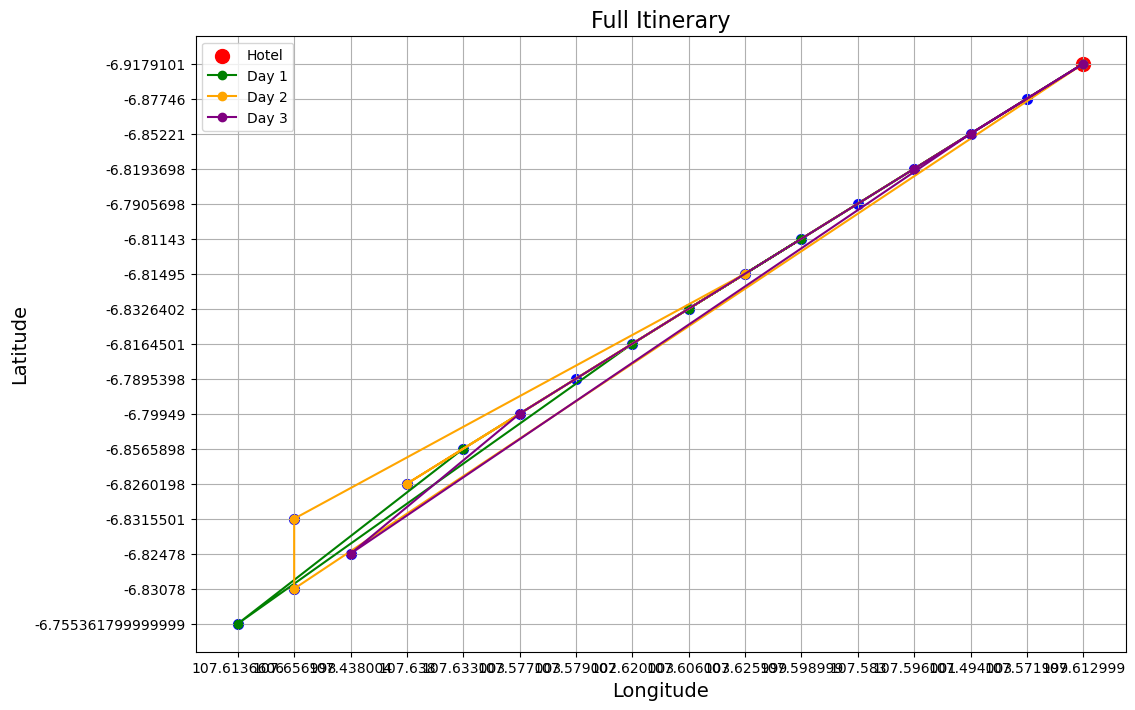

In [37]:
colors = ['green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta']

# plot full itinerary
plot_poi_and_hotel(hotel,tur)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('Full Itinerary', fontsize=16)
for i in range(len(node_solution)):
    longitudes = [node.long for node in node_solution[i]]
    latitudes = [node.lat for node in node_solution[i]]
    longitudes.insert(0, hotel.long)
    latitudes.insert(0, hotel.lat)
    longitudes.append(hotel.long)
    latitudes.append(hotel.lat)
    plt.plot(longitudes, latitudes, marker="o", color=colors[i], label=f'Day {i+1}')
plt.legend()
plt.grid()
plt.savefig('bandung_full.png', dpi=300, bbox_inches='tight')
plt.show()

## 87 POIs

In [11]:
def result_to_xlsx_all_poi(result,n,random_ls,filename):
    df_result = pd.DataFrame()
    for i in result:
        for j in range(len(result[i])):
            temp = pd.DataFrame(result[i][j],columns=["fitness","run_time"])
            temp['n'] = n[j]
            temp['method'] = i
            temp['random_seed'] = random_ls
            df_result = pd.concat([df_result,temp])
    df_result.to_excel(filename,index=False)

### All DOIs 1

In [6]:
n = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,87]
run_time_analysis = {
    "acs_vrp": [],
    "aco_vrp": [],
    "bso_vrp": [],
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
    "dka_vrp": [],
}
max_runtime = 100*60 #100 minutes
for i in n:
    print("n = ",i)
    random_ls = list(range(5,(5*30)+1,5))
    random_node = {
        "acs_vrp": [],
        "aco_vrp": [],
        "bso_vrp": [],
        "ga_vrp": [],
        "ts_vrp": [],
        "sa_vrp": [],
        "dka_vrp": [],
    }
    
    for j in range(len(random_ls)):
        # setting
        hotel,tur,timematrix = generate_data(n=i,random_state=random_ls[j])
        travel_days = 3
        dwaktu,dtarif,drating = 1,1,1
        
        print("random_state : ",random_ls[j])
        
        acs_vrp = ACS_VRP(random_state=100)
        results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["acs_vrp"].append([results_acs_vrp[key] for key in ["fitness","run_time"]])

        aco_vrp = ACO_VRP(random_state=100)
        results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["aco_vrp"].append([results_aco_vrp[key] for key in ["fitness","run_time"]])

        bso_vrp = BSO_VRP(random_state=100)
        results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["bso_vrp"].append([results_bso_vrp[key] for key in ["fitness","run_time"]])

        ga_vrp = GA_VRP(random_state=100)
        results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["ga_vrp"].append([results_ga_vrp[key] for key in ["fitness","run_time"]])

        ts_vrp = TS_VRP(random_state=100)
        results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["ts_vrp"].append([results_ts_vrp[key] for key in ["fitness","run_time"]])

        sa_vrp = SA_VRP(random_state=100)
        results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["sa_vrp"].append([results_sa_vrp[key] for key in ["fitness","run_time"]])

        dka_vrp = DKA_VRP(random_state=100)
        results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["dka_vrp"].append([results_dka_vrp[key] for key in ["fitness","run_time"]])
    
    for method in run_time_analysis:
        run_time_analysis[method].append(random_node[method])

n =  5
random_state :  5
random_state :  10
random_state :  15
random_state :  20
random_state :  25
random_state :  30
random_state :  35
random_state :  40
random_state :  45
random_state :  50
random_state :  55
random_state :  60
random_state :  65
random_state :  70
random_state :  75
random_state :  80
random_state :  85
random_state :  90
random_state :  95
random_state :  100
random_state :  105
random_state :  110
random_state :  115
random_state :  120
random_state :  125
random_state :  130
random_state :  135
random_state :  140
random_state :  145
random_state :  150
n =  10
random_state :  5
random_state :  10
random_state :  15
random_state :  20
random_state :  25
random_state :  30
random_state :  35
random_state :  40
random_state :  45
random_state :  50
random_state :  55
random_state :  60
random_state :  65
random_state :  70
random_state :  75
random_state :  80
random_state :  85
random_state :  90
random_state :  95
random_state :  100
random_state :  105
rando

random_state :  150
n =  75
random_state :  5
random_state :  10
random_state :  15
random_state :  20
random_state :  25
random_state :  30
random_state :  35
random_state :  40
random_state :  45
random_state :  50
random_state :  55
random_state :  60
random_state :  65
random_state :  70
random_state :  75
random_state :  80
random_state :  85
random_state :  90
random_state :  95
random_state :  100
random_state :  105
random_state :  110
random_state :  115
random_state :  120
random_state :  125
random_state :  130
random_state :  135
random_state :  140
random_state :  145
random_state :  150
n =  80
random_state :  5
random_state :  10
random_state :  15
random_state :  20
random_state :  25
random_state :  30
random_state :  35
random_state :  40
random_state :  45
random_state :  50
random_state :  55
random_state :  60
random_state :  65
random_state :  70
random_state :  75
random_state :  80
random_state :  85
random_state :  90
random_state :  95
random_state :  100
rand

In [7]:
run_time_analysis

{'acs_vrp': [[[0.7043981481481482, 0.17060542106628418],
   [0.7103086419753084, 0.17373061180114746],
   [0.7047839506172839, 0.1346147060394287],
   [0.7191358024691361, 0.11027312278747559],
   [0.7155864197530865, 0.11882972717285156],
   [0.8951080246913582, 0.13130402565002441],
   [0.6951388888888891, 0.1571207046508789],
   [0.675771604938272, 0.13203096389770508],
   [0.7184413580246914, 0.1461470127105713],
   [0.7366512345679014, 0.12027359008789062],
   [0.7224537037037037, 0.1265573501586914],
   [0.7318672839506174, 0.11803507804870605],
   [0.706327160493827, 0.13926124572753906],
   [0.6888888888888887, 0.12955188751220703],
   [0.731327160493827, 0.1507551670074463],
   [0.7006481481481485, 0.1469740867614746],
   [0.6806327160493826, 0.12880373001098633],
   [0.6866512345679013, 0.13558220863342285],
   [0.7046296296296295, 0.14490175247192383],
   [0.6915123456790123, 0.17252254486083984],
   [0.7013734567901236, 0.12031173706054688],
   [0.6847222222222221, 0.120939

In [13]:
result_to_xlsx_all_poi(run_time_analysis,n,random_ls,"dka_various_numbers_pois_all_1.xlsx")

In [16]:
#continue
n = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,87]
run_time_analysis = {
    "acs_vrp": [],
    "aco_vrp": [],
    "bso_vrp": [],
    "ga_vrp": [],
    "ts_vrp": [],
    "sa_vrp": [],
    "dka_vrp": [],
}
max_runtime = 100*60 #100 minutes
for i in n:
    print("n = ",i)
    random_ls = list(range(155,(5*50)+1,5))
    random_node = {
        "acs_vrp": [],
        "aco_vrp": [],
        "bso_vrp": [],
        "ga_vrp": [],
        "ts_vrp": [],
        "sa_vrp": [],
        "dka_vrp": [],
    }
    
    for j in range(len(random_ls)):
        # setting
        hotel,tur,timematrix = generate_data(n=i,random_state=random_ls[j])
        travel_days = 3
        dwaktu,dtarif,drating = 1,1,1
        
        print("random_state : ",random_ls[j])
        
        acs_vrp = ACS_VRP(random_state=100)
        results_acs_vrp = get_analysis(acs_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["acs_vrp"].append([results_acs_vrp[key] for key in ["fitness","run_time"]])

        aco_vrp = ACO_VRP(random_state=100)
        results_aco_vrp = get_analysis(aco_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["aco_vrp"].append([results_aco_vrp[key] for key in ["fitness","run_time"]])

        bso_vrp = BSO_VRP(random_state=100)
        results_bso_vrp = get_analysis(bso_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["bso_vrp"].append([results_bso_vrp[key] for key in ["fitness","run_time"]])

        ga_vrp = GA_VRP(random_state=100)
        results_ga_vrp = get_analysis(ga_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["ga_vrp"].append([results_ga_vrp[key] for key in ["fitness","run_time"]])

        ts_vrp = TS_VRP(random_state=100)
        results_ts_vrp = get_analysis(ts_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["ts_vrp"].append([results_ts_vrp[key] for key in ["fitness","run_time"]])

        sa_vrp = SA_VRP(random_state=100)
        results_sa_vrp = get_analysis(sa_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["sa_vrp"].append([results_sa_vrp[key] for key in ["fitness","run_time"]])

        dka_vrp = DKA_VRP(random_state=100)
        results_dka_vrp = get_analysis(dka_vrp,hotel,tur,timematrix,travel_days,dwaktu,dtarif,drating)
        random_node["dka_vrp"].append([results_dka_vrp[key] for key in ["fitness","run_time"]])
    
    for method in run_time_analysis:
        run_time_analysis[method].append(random_node[method])

n =  5
random_state :  155
random_state :  160
random_state :  165
random_state :  170
random_state :  175
random_state :  180
random_state :  185
random_state :  190
random_state :  195
random_state :  200
random_state :  205
random_state :  210
random_state :  215
random_state :  220
random_state :  225
random_state :  230
random_state :  235
random_state :  240
random_state :  245
random_state :  250
n =  10
random_state :  155
random_state :  160
random_state :  165
random_state :  170
random_state :  175
random_state :  180
random_state :  185
random_state :  190
random_state :  195
random_state :  200
random_state :  205
random_state :  210
random_state :  215
random_state :  220
random_state :  225
random_state :  230
random_state :  235
random_state :  240
random_state :  245
random_state :  250
n =  15
random_state :  155
random_state :  160
random_state :  165
random_state :  170
random_state :  175
random_state :  180
random_state :  185
random_state :  190
random_state :  1

In [17]:
run_time_analysis

{'acs_vrp': [[[0.7221141975308644, 0.20485758781433105],
   [0.7264126305792972, 0.1662287712097168],
   [0.6655864197530871, 0.1965022087097168],
   [0.7003086419753087, 0.16663432121276855],
   [0.7229938271604941, 0.21277832984924316],
   [0.7336419753086418, 0.15607309341430664],
   [0.7039351851851855, 0.1601564884185791],
   [0.7273919753086419, 0.13993430137634277],
   [0.6786265432098766, 0.2262251377105713],
   [0.7202932098765431, 0.20003223419189453],
   [0.7216820987654322, 0.17191433906555176],
   [0.7464576318742985, 0.13518595695495605],
   [0.7043209876543206, 0.2515721321105957],
   [0.7262808641975309, 0.22178006172180176],
   [0.6860339506172838, 0.15533208847045898],
   [0.7126543209876545, 0.16411328315734863],
   [0.6540895061728403, 0.2516474723815918],
   [0.713503086419753, 0.17514586448669434],
   [0.7217592592592593, 0.14107799530029297],
   [0.9045524691358026, 0.15718984603881836]],
  [[0.6704783950617285, 0.7410812377929688],
   [0.6924382716049383, 1.0776

In [19]:
result_to_xlsx_all_poi(run_time_analysis,n,random_ls,"dka_various_numbers_pois_all_1_v2.xlsx")

# Uji Statistik

In [46]:
def uji_statistik(first_data,second_data,alternative="two-sided",first_data_name="first",second_data_name="second"):
    # first_data is the target data, e.g. the results of Hybrid ACS-BSO 
    # second_data is a list of results from other method
    # the test is using Wilcoxon Rank-Sum Test
    p_values = []
    second_data_name = ["second" for i in range(len(second_data))] if second_data_name == "second" else second_data_name
    for i in range(len(second_data)):
        statistic, p_value = stats.ranksums(first_data, second_data[i],alternative=alternative)
        p_values.append(p_value)
        print(f"Wilcoxon Rank-Sum Test ({first_data_name} vs. {second_data_name[i]}):")
        print("Test Statistic:", statistic)
        print("p-value:", p_value)
        print("")
    return p_values

def save_to_excel_sheet(df,filename,sheet_name):
    try:
        with pd.ExcelWriter(filename, mode="a", engine="openpyxl", if_sheet_exists='replace') as writer:

            # use to_excel function and specify the sheet_name and index to 
            # store the dataframe in specified sheet
            df.to_excel(writer, sheet_name=sheet_name, index=False)
    except:
        with pd.ExcelWriter(filename, mode="w", engine="openpyxl") as writer:

            # use to_excel function and specify the sheet_name and index to 
            # store the dataframe in specified sheet
            df.to_excel(writer, sheet_name=sheet_name, index=False)

## Hyperparameter Tuning

### Iteration Convergence

In [52]:
results_df = pd.read_excel("dka_iteration_convergence.xlsx")
results_df.head()

,iter,best_fitness,doi_combi
0,1,0.596798,"1,1,1"
1,2,0.596798,"1,1,1"
2,3,0.598599,"1,1,1"
3,4,0.598599,"1,1,1"
4,5,0.598599,"1,1,1"


In [53]:
results_df = results_df.pivot(index=['iter'],columns='doi_combi',values='best_fitness').reset_index()
results_df

doi_combi,iter,"0,0,1","0,1,0","1,0,0","1,1,1"
0,1,0.735714,0.754738,0.604745,0.596798
1,2,0.735714,0.754738,0.604745,0.596798
2,3,0.735714,0.754738,0.606019,0.598599
3,4,0.737362,0.754738,0.606019,0.598599
4,5,0.737362,0.754738,0.606019,0.598599
...,...,...,...,...,...
116,117,NaN,NaN,NaN,0.643400
117,118,NaN,NaN,NaN,0.643400
118,119,NaN,NaN,NaN,0.643400
119,120,NaN,NaN,NaN,0.643400


In [54]:
save_to_excel_sheet(results_df,filename="dka_experiment_results.xlsx",sheet_name="iteration_convergence_results")

### Parameter Tuning

In [25]:
results_df = pd.read_excel("dka_tuning_n_parameter.xlsx")
results_df.head()

,n,fitness,run_time
0,5,0.643400,2.266844
1,10,0.666665,6.990387
2,15,0.664651,17.575596
3,20,0.673871,60.898961


In [26]:
save_to_excel_sheet(results_df,filename="dka_experiment_results.xlsx",sheet_name="tuning_n_parameter_results")

## Outlier Sensitivity

In [6]:
results_df = pd.read_excel("dka_outlier_sensitivity.xlsx")
results_df2 = pd.read_excel("kma_outlier_sensitivity.xlsx")
results_df3 = pd.read_excel("pso_outlier_sensitivity.xlsx")
results_df4 = pd.read_excel("ils_outlier_sensitivity.xlsx")
results_df = pd.concat([results_df,results_df2,results_df3,results_df4])
results_df.head()

,methods,num_outlier,travel_days
0,dka_vrp,0,1
1,acs_vrp,0,1
2,aco_vrp,0,1
3,bso_vrp,0,1
4,ga_vrp,0,1


In [7]:
results_df = results_df.pivot(index=['travel_days'],columns='methods',values='num_outlier').reset_index()

In [8]:
save_to_excel_sheet(results_df,filename="dka_experiment_results.xlsx",sheet_name="outlier_sensitivity_results")

## General performance

### All DOI 1

In [9]:
results_df = pd.read_excel("dka_random_nodes_alldoi_1.xlsx")
results_df2 = pd.read_excel("kma_random_nodes_alldoi_1.xlsx")
results_df3 = pd.read_excel("pso_random_nodes_alldoi_1.xlsx")
results_df4 = pd.read_excel("ils_random_nodes_alldoi_1.xlsx")
results_df = pd.concat([results_df,results_df2,results_df3,results_df4])
results_df.head()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time,method
0,5,0.681458,0.709375,0.625561,0.650876,21,4.614286,37000,125100,4.769661,acs_vrp
1,10,0.644172,0.631843,0.602275,0.602765,20,4.580000,24500,124620,3.170985,acs_vrp
2,15,0.611977,0.603838,0.579350,0.546002,21,4.633333,81500,126480,2.801009,acs_vrp
3,20,0.678256,0.665319,0.629272,0.618132,22,4.590909,41000,122520,3.208303,acs_vrp
4,25,0.628851,0.631071,0.607775,0.587981,20,4.560000,86000,121860,5.879171,acs_vrp


In [10]:
grouped = results_df.groupby('method').agg(fitness = ('fitness','mean'),
                                           std_fitness = ('fitness','std'),
                                           run_time = ('run_time','mean'),
                                           std_run_time = ('run_time','std')).reset_index()
grouped.sort_values('fitness',ascending=False)

,method,fitness,std_fitness,run_time,std_run_time
1,acs_vrp,0.659326,0.024286,3.746193,1.383804
12,sa_vrp,0.658175,0.024231,0.971710,0.035800
9,kma_vrp,0.656306,0.024101,5.064276,2.320104
10,mga_vrp,0.655660,0.027014,0.540331,0.072410
11,pso_vrp,0.647372,0.025445,0.604844,0.156425
14,vns_vrp,0.642761,0.028333,0.167079,0.074258
3,dka_vrp,0.640759,0.023786,0.462857,0.215773
15,woa_vrp,0.640459,0.024909,0.414673,0.132829
13,ts_vrp,0.640236,0.025841,0.665049,0.023877
0,aco_vrp,0.639912,0.027561,2.691196,0.641916


In [11]:
metrics = ["fitness","run_time"]

df_stat = pd.DataFrame()
for metric in metrics:
    print("metric: ",metric)
    metrics = metric
    alternative = "two-sided"
    first_data = results_df[results_df['method']=="dka_vrp"][metrics].values
    first_data_name = "dka_vrp"

    second_data = []
    second_data_name = []
    for method in results_df[~results_df['method'].isin(["dka_vrp"])]['method'].unique():
        second_data.append(results_df[results_df['method']==method][metrics].values)
        second_data_name.append(method)

    p_values = uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)
    df_stat = pd.concat([df_stat,pd.DataFrame({'metrics':metric,
                                               'method':second_data_name,
                                               'p_value':p_values})])

metric:  fitness
Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: -3.660618353867727
p-value: 0.0002516072978259805

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: -0.40673537265196963
p-value: 0.6842023576175498

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: 8.293265310174906
p-value: 1.1018121083880995e-16

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: 1.8751190061243346
p-value: 0.060776353380831025

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: -0.42052301240288387
p-value: 0.6741034218588211

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: -3.433122297977642
p-value: 0.0005966728938228825

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -3.260776801091214
p-value: 0.0011110746216913378

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: -0.2137084161391705
p-value: 0.8307744478348679

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: -1.0133915216921956
p-val

In [12]:
df_stat

,metrics,method,p_value
0,fitness,acs_vrp,2.516073e-04
1,fitness,aco_vrp,6.842024e-01
2,fitness,bso_vrp,1.101812e-16
3,fitness,ga_vrp,6.077635e-02
4,fitness,ts_vrp,6.741034e-01
5,fitness,sa_vrp,5.966729e-04
6,fitness,kma_vrp,1.111075e-03
7,fitness,woa_vrp,8.307744e-01
8,fitness,vns_vrp,3.108732e-01
9,fitness,pso_vrp,1.082168e-01


In [13]:
save_to_excel_sheet(grouped.sort_values('fitness',ascending=False),filename="dka_experiment_results.xlsx",sheet_name="alldoi_1_results")
save_to_excel_sheet(df_stat,filename="dka_experiment_results.xlsx",sheet_name="alldoi_1_p_value")

### Travel Duration 1

In [14]:
results_df = pd.read_excel("dka_random_nodes_dwaktu_1.xlsx")
results_df2 = pd.read_excel("kma_random_nodes_dwaktu_1.xlsx")
results_df3 = pd.read_excel("pso_random_nodes_dwaktu_1.xlsx")
results_df4 = pd.read_excel("ils_random_nodes_dwaktu_1.xlsx")
results_df = pd.concat([results_df,results_df2,results_df3,results_df4])
results_df.head()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time,method
0,5,0.648032,0.510880,0.424074,0.477778,23,4.556522,104500,121980,3.011678,acs_vrp
1,10,0.642361,0.487963,0.472685,0.440741,23,4.534783,196000,124920,4.785303,acs_vrp
2,15,0.631211,0.481481,0.438426,0.463657,23,4.604348,260500,129540,3.239691,acs_vrp
3,20,0.663850,0.483102,0.487037,0.457639,24,4.558333,283000,122400,3.555043,acs_vrp
4,25,0.626852,0.468287,0.459491,0.459259,22,4.500000,205500,124320,7.371741,acs_vrp


In [15]:
grouped = results_df.groupby('method').agg(fitness = ('fitness','mean'),
                                           std_fitness = ('fitness','std'),
                                           run_time = ('run_time','mean'),
                                           std_run_time = ('run_time','std')).reset_index()
grouped.sort_values('fitness',ascending=False)

,method,fitness,std_fitness,run_time,std_run_time
1,acs_vrp,0.653629,0.019778,3.864807,1.499588
9,kma_vrp,0.652954,0.020802,6.356812,2.741273
0,aco_vrp,0.652414,0.022920,2.674487,0.692401
12,sa_vrp,0.651903,0.019467,0.946983,0.011019
10,mga_vrp,0.646004,0.021900,0.513543,0.082797
11,pso_vrp,0.643566,0.019813,0.620332,0.201708
13,ts_vrp,0.641319,0.022155,0.648231,0.017646
14,vns_vrp,0.640123,0.022411,0.164907,0.069094
3,dka_vrp,0.637856,0.023063,0.436884,0.205289
15,woa_vrp,0.634821,0.022032,0.430723,0.106478


In [16]:
metrics = ["fitness","run_time"]

df_stat = pd.DataFrame()
for metric in metrics:
    print("metric: ",metric)
    metrics = metric
    alternative = "two-sided"
    first_data = results_df[results_df['method']=="dka_vrp"][metrics].values
    first_data_name = "dka_vrp"

    second_data = []
    second_data_name = []
    for method in results_df[~results_df['method'].isin(["dka_vrp"])]['method'].unique():
        second_data.append(results_df[results_df['method']==method][metrics].values)
        second_data_name.append(method)

    p_values = uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)
    df_stat = pd.concat([df_stat,pd.DataFrame({'metrics':metric,
                                               'method':second_data_name,
                                               'p_value':p_values})])

metric:  fitness
Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: -3.4917197669190276
p-value: 0.0004799214751372957

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: -3.102218943955701
p-value: 0.0019207584104581645

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: 6.587044890999271
p-value: 4.486666614971876e-11

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: 1.9233757452525344
p-value: 0.054432878152186996

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: -0.8582805744944105
p-value: 0.390737553235738

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: -3.029833835263401
p-value: 0.0024468831891312623

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -3.2228607917762004
p-value: 0.001269172182826938

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: 0.7548732763625539
p-value: 0.4503250216950171

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: -0.6445721583552401
p-value

In [17]:
save_to_excel_sheet(grouped.sort_values('fitness',ascending=False),filename="dka_experiment_results.xlsx",sheet_name="dwaktu_1_results")
save_to_excel_sheet(df_stat,filename="dka_experiment_results.xlsx",sheet_name="dwaktu_1_p_value")

### Tarif 1

In [20]:
results_df = pd.read_excel("dka_random_nodes_dtarif_1.xlsx")
results_df2 = pd.read_excel("kma_random_nodes_dtarif_1.xlsx")
results_df3 = pd.read_excel("pso_random_nodes_dtarif_1.xlsx")
results_df4 = pd.read_excel("ils_random_nodes_dtarif_1.xlsx")
results_df = pd.concat([results_df,results_df2,results_df3,results_df4])
results_df.head()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time,method
0,5,0.809434,0.593082,0.592138,0.583648,21,4.604762,43000,128340,1.987593,acs_vrp
1,10,0.807227,0.575221,0.607817,0.598083,20,4.565000,29500,127380,4.700382,acs_vrp
2,15,0.791200,0.622184,0.550649,0.561034,21,4.623810,83500,129600,3.271467,acs_vrp
3,20,0.841992,0.639924,0.627036,0.550588,22,4.586364,39000,127800,5.548777,acs_vrp
4,25,0.780875,0.588576,0.555925,0.569949,21,4.528571,106000,126180,3.074423,acs_vrp


In [21]:
grouped = results_df.groupby('method').agg(fitness = ('fitness','mean'),
                                           std_fitness = ('fitness','std'),
                                           run_time = ('run_time','mean'),
                                           std_run_time = ('run_time','std')).reset_index()
grouped.sort_values('fitness',ascending=False)

,method,fitness,std_fitness,run_time,std_run_time
9,kma_vrp,0.826179,0.021846,4.624728,1.966471
12,sa_vrp,0.825749,0.021078,0.957705,0.016814
1,acs_vrp,0.825103,0.022411,3.643509,1.205659
11,pso_vrp,0.814867,0.021476,0.515292,0.151636
10,mga_vrp,0.808954,0.026028,0.353386,0.082856
13,ts_vrp,0.807096,0.025027,0.663548,0.018284
15,woa_vrp,0.803911,0.026580,0.365912,0.086163
3,dka_vrp,0.799982,0.026349,0.406919,0.190630
14,vns_vrp,0.795416,0.034217,0.117696,0.053228
4,ga_vrp,0.794564,0.027925,0.767411,0.348168


In [22]:
metrics = ["fitness","run_time"]

df_stat = pd.DataFrame()
for metric in metrics:
    print("metric: ",metric)
    metrics = metric
    alternative = "two-sided"
    first_data = results_df[results_df['method']=="dka_vrp"][metrics].values
    first_data_name = "dka_vrp"

    second_data = []
    second_data_name = []
    for method in results_df[~results_df['method'].isin(["dka_vrp"])]['method'].unique():
        second_data.append(results_df[results_df['method']==method][metrics].values)
        second_data_name.append(method)

    p_values = uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)
    df_stat = pd.concat([df_stat,pd.DataFrame({'metrics':metric,
                                               'method':second_data_name,
                                               'p_value':p_values})])

metric:  fitness
Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: -4.5154520184244085
p-value: 6.318185160126762e-06

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: 1.9923139440071056
p-value: 0.046336622708105214

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: 8.59659338469502
p-value: 8.211730646555817e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: 0.8272583850548535
p-value: 0.40809062551680486

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: -1.2684628570841088
p-value: 0.2046327068387458

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: -4.639540776182637
p-value: 3.4918423568998417e-06

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -4.5774963973035225
p-value: 4.7057389178179324e-06

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: -0.8065769254284822
p-value: 0.41991027219796906

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: 0.5928685092893117
p-val

In [23]:
save_to_excel_sheet(grouped.sort_values('fitness',ascending=False),filename="dka_experiment_results.xlsx",sheet_name="dtarif_1_results")
save_to_excel_sheet(df_stat,filename="dka_experiment_results.xlsx",sheet_name="dtarif_1_p_value")

### Rating 1

In [24]:
results_df = pd.read_excel("dka_random_nodes_drating_1.xlsx")
results_df2 = pd.read_excel("kma_random_nodes_drating_1.xlsx")
results_df3 = pd.read_excel("pso_random_nodes_drating_1.xlsx")
results_df4 = pd.read_excel("ils_random_nodes_drating_1.xlsx")
results_df = pd.concat([results_df,results_df2,results_df3,results_df4])
results_df.head()

,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time,method
0,5,0.826339,0.594444,0.498148,0.445833,23,4.595652,179500,128040,2.198029,acs_vrp
1,10,0.774953,0.477083,0.402381,0.358333,23,4.569565,142000,129420,5.177960,acs_vrp
2,15,0.738227,0.454762,0.320748,0.310544,22,4.640909,151500,126180,3.272198,acs_vrp
3,20,0.795721,0.550000,0.427778,0.377778,23,4.591304,235000,127980,1.410371,acs_vrp
4,25,0.750396,0.483333,0.395455,0.365152,21,4.566667,139000,127080,2.331297,acs_vrp


In [25]:
grouped = results_df.groupby('method').agg(fitness = ('fitness','mean'),
                                           std_fitness = ('fitness','std'),
                                           run_time = ('run_time','mean'),
                                           std_run_time = ('run_time','std')).reset_index()
grouped.sort_values('fitness',ascending=False)

,method,fitness,std_fitness,run_time,std_run_time
9,kma_vrp,0.799579,0.033538,5.528577,2.419058
1,acs_vrp,0.796156,0.035199,3.169225,1.399642
12,sa_vrp,0.793384,0.033063,0.963424,0.018638
11,pso_vrp,0.787471,0.034832,0.540462,0.162198
13,ts_vrp,0.785960,0.033824,0.673597,0.021443
15,woa_vrp,0.782584,0.033836,0.398832,0.088496
3,dka_vrp,0.780811,0.031814,0.407809,0.196857
14,vns_vrp,0.779596,0.035539,0.123323,0.056490
10,mga_vrp,0.779486,0.032997,0.339333,0.081625
0,aco_vrp,0.775737,0.034899,2.412886,0.363135


In [26]:
metrics = ["fitness","run_time"]

df_stat = pd.DataFrame()
for metric in metrics:
    print("metric: ",metric)
    metrics = metric
    alternative = "two-sided"
    first_data = results_df[results_df['method']=="dka_vrp"][metrics].values
    first_data_name = "dka_vrp"

    second_data = []
    second_data_name = []
    for method in results_df[~results_df['method'].isin(["dka_vrp"])]['method'].unique():
        second_data.append(results_df[results_df['method']==method][metrics].values)
        second_data_name.append(method)

    p_values = uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)
    df_stat = pd.concat([df_stat,pd.DataFrame({'metrics':metric,
                                               'method':second_data_name,
                                               'p_value':p_values})])

metric:  fitness
Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: -2.323217298029047
p-value: 0.02016748197034859

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: 0.6824881676702542
p-value: 0.49493032211762333

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: 6.845563136328913
p-value: 7.617561341263654e-12

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: 0.7686609161134681
p-value: 0.44209463261794313

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: -0.854833664556682
p-value: 0.3926432384291334

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: -1.95784484462982
p-value: 0.050248221503831035

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -2.7851032296846734
p-value: 0.00535106842508092

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: -0.272305885080556
p-value: 0.7853868315060774

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: 0.19302695651279916
p-value: 0.84693

In [27]:
save_to_excel_sheet(grouped.sort_values('fitness',ascending=False),filename="dka_experiment_results.xlsx",sheet_name="drating_1_results")
save_to_excel_sheet(df_stat,filename="dka_experiment_results.xlsx",sheet_name="drating_1_p_value")

## DOI Combination

In [43]:
results_df = pd.read_excel("dka_bdg_random_doi_combi.xlsx")
# results_df2 = pd.read_excel("kma_random_doi_combi.xlsx")
# results_df3 = pd.read_excel("pso_random_doi_combi.xlsx")
# results_df4 = pd.read_excel("ils_random_doi_combi.xlsx")
# results_df = pd.concat([results_df,results_df2,results_df3,results_df4])
results_df.head()

,dwaktu,dtarif,drating,method,random_seed,fitness,fitness_1,fitness_2,fitness_3,poi_included,rating,tarif,total_duration,run_time
0,0.15,0.45,0.77,dka_vrp,5,0.789112,0.594096,0.583530,0.585864,13,3.923077,165500,119400,1.152236
1,0.15,0.45,0.77,dka_vrp,10,0.787714,0.599917,0.587692,0.573303,13,3.923077,165500,124680,1.020750
2,0.15,0.45,0.77,dka_vrp,15,0.788270,0.630759,0.555365,0.572204,13,3.923077,165500,122580,0.988050
3,0.15,0.45,0.77,dka_vrp,20,0.788365,0.614694,0.535268,0.604329,13,3.923077,165500,122220,0.629976
4,0.15,0.45,0.77,dka_vrp,25,0.787302,0.584653,0.595441,0.579101,13,3.923077,165500,124500,0.268917


In [44]:
grouped = results_df.groupby(['dwaktu','dtarif','drating','method']).agg(fitness = ('fitness','mean'),
                                                                         std_fitness = ('fitness','std'),
                                                                         run_time = ('run_time','mean'),
                                                                         std_run_time = ('run_time','std'))

grouped

,,,,fitness,std_fitness,run_time,std_run_time
dwaktu,dtarif,drating,method,,,,
0.15,0.45,0.77,dka_vrp,0.788302,0.000616,0.722804,0.282662
0.16,0.65,0.12,dka_vrp,0.748104,0.001729,0.666389,0.240744
0.19,0.35,0.63,dka_vrp,0.789559,0.001302,0.547390,0.317395
0.46,0.05,0.93,dka_vrp,0.787483,0.003278,0.707767,0.329193
0.56,0.90,0.82,dka_vrp,0.695801,0.002676,0.516764,0.260875
0.71,0.73,0.43,dka_vrp,0.673869,0.002671,0.504039,0.163675
0.77,0.20,0.18,dka_vrp,0.699519,0.004665,0.578961,0.276868
0.80,0.53,0.08,dka_vrp,0.659576,0.003545,0.592330,0.211079
0.95,0.34,0.31,dka_vrp,0.664065,0.004641,0.419422,0.146853


In [47]:
save_to_excel_sheet(grouped.reset_index(),filename="bdg_dka_experiment_results.xlsx",sheet_name="doi_combi_results")

In [31]:
random.seed(100)
doi_combi = [(np.round(random.uniform(0,1),2),np.round(random.uniform(0,1),2),np.round(random.uniform(0,1),2)) for i in range(10)]

In [32]:
df_stat = pd.DataFrame()
for doi in doi_combi:
    print("doi combination : ",doi)
    metrics = "fitness"
    print("metric: ",metrics)
    alternative = "two-sided"
    first_data = results_df[(results_df['method']=="dka_vrp")&
                        (results_df['dwaktu']==doi[0])&
                        (results_df['dtarif']==doi[1])&
                        (results_df['drating']==doi[2])][metrics].values
    first_data_name = "dka_vrp"

    second_data = []
    second_data_name = []
    for method in results_df[~results_df['method'].isin(["dka_vrp"])]['method'].unique():
        second_data.append(results_df[(results_df['method']==method)&
                        (results_df['dwaktu']==doi[0])&
                        (results_df['dtarif']==doi[1])&
                        (results_df['drating']==doi[2])][metrics].values)
        second_data_name.append(method)

    p_values = uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)
    df_stat = pd.concat([df_stat,pd.DataFrame({'dwaktu':doi[0],
                                               'dtarif':doi[1],
                                               'drating':doi[2],
                                               'metrics':metrics,
                                               'method':second_data_name,
                                               'p_value':p_values})])

doi combination :  (0.15, 0.45, 0.77)
metric:  fitness
Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: -2.143977981267162
p-value: 0.03203465109154384

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: 1.3029319564613944
p-value: 0.19259799276641898

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: 7.486688384746425
p-value: 7.063313496311528e-14

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: 2.0957212421389624
p-value: 0.03610692636685788

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: 0.3446909937728556
p-value: 0.7303266896009318

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: -1.895800465750706
p-value: 0.057986434276740335

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -2.130190341516248
p-value: 0.03315590213557952

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: 0.97892242231491
p-value: 0.3276183123071674

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: 

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -2.8954043476919873
p-value: 0.003786704151057738

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: 0.33779717389739855
p-value: 0.7355160397405875

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: -0.7307449067984539
p-value: 0.464934980549941

Wilcoxon Rank-Sum Test (dka_vrp vs. pso_vrp):
Test Statistic: -0.9582409626885386
p-value: 0.33794126596326657

Wilcoxon Rank-Sum Test (dka_vrp vs. ils_vrp):
Test Statistic: 3.8260700308786975
p-value: 0.00013020526280546052

Wilcoxon Rank-Sum Test (dka_vrp vs. ils_sa_vrp):
Test Statistic: 2.1508718011426193
p-value: 0.031486319835581415

Wilcoxon Rank-Sum Test (dka_vrp vs. ils_ts_vrp):
Test Statistic: 3.9019020495087258
p-value: 9.543977939453069e-05

Wilcoxon Rank-Sum Test (dka_vrp vs. ils_sa_ts_vrp):
Test Statistic: 2.0957212421389624
p-value: 0.03610692636685788

Wilcoxon Rank-Sum Test (dka_vrp vs. mga_vrp):
Test Statistic: -2.6403330123000743
p-value: 0

In [33]:
df_stat2 = pd.DataFrame()
for doi in doi_combi:
    print("doi combination : ",doi)
    metrics = "run_time"
    print("metric: ",metrics)
    alternative = "two-sided"
    first_data = results_df[(results_df['method']=="dka_vrp")&
                        (results_df['dwaktu']==doi[0])&
                        (results_df['dtarif']==doi[1])&
                        (results_df['drating']==doi[2])][metrics].values
    first_data_name = "dka_vrp"

    second_data = []
    second_data_name = []
    for method in results_df[~results_df['method'].isin(["dka_vrp"])]['method'].unique():
        second_data.append(results_df[(results_df['method']==method)&
                        (results_df['dwaktu']==doi[0])&
                        (results_df['dtarif']==doi[1])&
                        (results_df['drating']==doi[2])][metrics].values)
        second_data_name.append(method)

    p_values = uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)
    df_stat2 = pd.concat([df_stat2,pd.DataFrame({'dwaktu':doi[0],
                                               'dtarif':doi[1],
                                               'drating':doi[2],
                                               'metrics':metrics,
                                               'method':second_data_name,
                                               'p_value':p_values})])

doi combination :  (0.15, 0.45, 0.77)
metric:  run_time
Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: 1.3856577949668796
p-value: 0.16585142133848707

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: -4.2948497824097815
p-value: 1.7481166264969505e-05

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: -4.329318881787067
p-value: 1.4957122399174373e-05

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: -7.376387266739111
p-value: 1.62642478199907e-13

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: 0.46533284159335514
p-value: 0.6416931196450413

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):

Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: 1.7234549688642782
p-value: 0.08480628179936625

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: -4.680903695435379
p-value: 2.856130942745735e-06

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: -5.177258726468292
p-value: 2.2516985645008115e-07

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: -8.28637149029945
p-value: 1.1675572001380731e-16

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: -0.5170364906592835
p-value: 0.6051306860284573

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: 7.948574316402051
p-value: 1.88670144807

In [34]:
df_stat = df_stat.pivot(index=['metrics','dwaktu','dtarif','drating'],columns='method',values='p_value').reset_index()
df_stat2 = df_stat2.pivot(index=['metrics','dwaktu','dtarif','drating'],columns='method',values='p_value').reset_index()
df_stat = pd.concat([df_stat,df_stat2])

In [35]:
grouped1 = grouped.reset_index().copy()
grouped1['metrics'] = 'fitness'
grouped1 = grouped1.pivot(index=['metrics','dwaktu','dtarif','drating'],columns='method',values='fitness').reset_index()

grouped2 = grouped.reset_index().copy()
grouped2['metrics'] = 'run_time'
grouped2 = grouped2.pivot(index=['metrics','dwaktu','dtarif','drating'],columns='method',values='run_time').reset_index()

grouped3 = grouped.reset_index().copy()
grouped3['metrics'] = 'std_fitness'
grouped3 = grouped3.pivot(index=['metrics','dwaktu','dtarif','drating'],columns='method',values='std_fitness').reset_index()

grouped4 = grouped.reset_index().copy()
grouped4['metrics'] = 'std_run_time'
grouped4 = grouped4.pivot(index=['metrics','dwaktu','dtarif','drating'],columns='method',values='std_run_time').reset_index()


grouped = pd.concat([grouped1,grouped2,grouped3,grouped4])

In [36]:
save_to_excel_sheet(grouped,filename="dka_experiment_results.xlsx",sheet_name="doi_combi_results")
save_to_excel_sheet(df_stat,filename="dka_experiment_results.xlsx",sheet_name="doi_combi_p_value")

## All POI

In [37]:
results_df1 = pd.read_excel("dka_various_numbers_pois_all_1.xlsx")
results_df2 = pd.read_excel("dka_various_numbers_pois_all_1_v2.xlsx")
results_df3 = pd.read_excel("kma_various_numbers_pois_all_1.xlsx")
results_df4 = pd.read_excel("pso_various_numbers_pois_all_1.xlsx")
results_df5 = pd.read_excel("ils_various_numbers_pois_all_1.xlsx")
results_df = pd.concat([results_df1,results_df2,results_df3,results_df4,results_df5])
results_df = results_df.reset_index(drop=True)
results_df.head()

,fitness,run_time,n,method,random_seed
0,0.704398,0.170605,5,acs_vrp,5
1,0.710309,0.173731,5,acs_vrp,10
2,0.704784,0.134615,5,acs_vrp,15
3,0.719136,0.110273,5,acs_vrp,20
4,0.715586,0.118830,5,acs_vrp,25


In [38]:
grouped = results_df.groupby(['method','n']).agg(fitness = ('fitness','mean'),
                                                 std_fitness = ('fitness','std'),
                                                 run_time = ('run_time','mean'),
                                                 std_run_time = ('run_time','std')).copy()

In [39]:
n = results_df['n'].unique()
n.sort()
metric = "fitness"
alternative = "two-sided"

df_stat = pd.DataFrame()
for i in n:
    print("n: ",i)
    first_data = results_df[(results_df['method']=="dka_vrp")&(results_df['n']==i)][metric].values
    first_data_name = "dka_vrp"

    second_data = []
    second_data_name = []
    for method in results_df[results_df['method'] != "dka_vrp"]['method'].unique():
        second_data.append(results_df[(results_df['method']==method)&(results_df['n']==i)][metric].values)
        second_data_name.append(method)

    p_values = uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)
    df_stat = pd.concat([df_stat,pd.DataFrame({'n':i,
                                               'metrics':metric,
                                               'method':second_data_name,
                                               'p_value':p_values})])

n:  5
Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: 0.017234549688642783
p-value: 0.9862494996122527

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: 0.2309429658278133
p-value: 0.8173591109195852

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: 0.6514659782306972
p-value: 0.5147457320739065

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: 0.04136291925274268
p-value: 0.9670065736331777

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: 0.0
p-value: 1.0

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: 0.15511094719778504
p-value: 0.8767338520233376

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: 0.0
p-value: 1.0

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: 0.04825673912819979
p-value: 0.9615116315341786

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: 0.2309429658278133
p-value: 0.8173591109195852

Wilcoxon Rank-Sum Test (dka_vrp vs. pso_vrp):
Test Statistic: 

Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: -3.660618353867727
p-value: 0.0002516072978259805

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: -0.40673537265196963
p-value: 0.6842023576175498

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: 8.293265310174906
p-value: 1.1018121083880995e-16

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: 1.8751190061243346
p-value: 0.060776353380831025

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: -0.42052301240288387
p-value: 0.6741034218588211

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: -3.433122297977642
p-value: 0.0005966728938228825

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -3.260776801091214
p-value: 0.0011110746216913378

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: -0.2137084161391705
p-value: 0.8307744478348679

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: -1.0133915216921956
p-value: 0.31087318745

Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: -8.320840589676735
p-value: 8.734165225620056e-17

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: -7.693502981010138
p-value: 1.4316037008407338e-14

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: 7.272979968607254
p-value: 3.5164248329970405e-13

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: 0.8479398446812249
p-value: 0.3964714729625185

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: -4.398257080541638
p-value: 1.0912367447666874e-05

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: -6.045880030775888
p-value: 1.4859664116044336e-09

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -8.010618695281165
p-value: 1.141328016223929e-15

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: -3.0194931054502154
p-value: 0.0025319805586937762

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: -3.109112763831158
p-value: 0.001876

In [40]:
n = results_df['n'].unique()
n.sort()
metric = "run_time"
alternative = "two-sided"

df_stat2 = pd.DataFrame()
for i in n:
    print("n: ",i)
    first_data = results_df[(results_df['method']=="dka_vrp")&(results_df['n']==i)][metric].values
    first_data_name = "dka_vrp"

    second_data = []
    second_data_name = []
    for method in results_df[results_df['method'] != "dka_vrp"]['method'].unique():
        second_data.append(results_df[(results_df['method']==method)&(results_df['n']==i)][metric].values)
        second_data_name.append(method)

    p_values = uji_statistik(first_data,second_data,alternative=alternative,first_data_name=first_data_name,second_data_name=second_data_name)
    df_stat2 = pd.concat([df_stat2,pd.DataFrame({'n':i,
                                               'metrics':metric,
                                               'method':second_data_name,
                                               'p_value':p_values})])

n:  5
Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: 5.983835651896774
p-value: 2.1794322776441375e-09

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: -8.59659338469502
p-value: 8.211730646555817e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: 8.617274844321392
p-value: 6.856

Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: 1.8199684471206778
p-value: 0.06876381010880288

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: -5.294453664351063
p-value: 1.1937275114504229e-07

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: -5.708082856878489
p-value: 1.1425580001484516e-08

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: -8.300159130050364
p-value: 1.0397203684846393e-16

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: 0.9513471428130815
p-value: 0.34142818298452027

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: 7.73486590026288
p-value: 1.0351215406

Wilcoxon Rank-Sum Test (dka_vrp vs. acs_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. aco_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. bso_vrp):
Test Statistic: -8.603487204570477
p-value: 7.73298779987613e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. ga_vrp):
Test Statistic: -2.5782886334209603
p-value: 0.009929102314560907

Wilcoxon Rank-Sum Test (dka_vrp vs. ts_vrp):
Test Statistic: -3.2814582607175855
p-value: 0.0010327180791226923

Wilcoxon Rank-Sum Test (dka_vrp vs. sa_vrp):
Test Statistic: -7.659033881632852
p-value: 1.873369754505005e-14

Wilcoxon Rank-Sum Test (dka_vrp vs. kma_vrp):
Test Statistic: -8.617274844321392
p-value: 6.856641447475644e-18

Wilcoxon Rank-Sum Test (dka_vrp vs. woa_vrp):
Test Statistic: 1.7234549688642782
p-value: 0.08480628179936625

Wilcoxon Rank-Sum Test (dka_vrp vs. vns_vrp):
Test Statistic: 7.852060838145651
p-value: 4.0925586665

In [41]:
df_stat = df_stat.pivot(index=['metrics','n'],columns='method',values='p_value').reset_index()
df_stat2 = df_stat2.pivot(index=['metrics','n'],columns='method',values='p_value').reset_index()
df_stat = pd.concat([df_stat,df_stat2])

In [42]:
grouped1 = grouped.reset_index().copy()
grouped1['metrics'] = 'fitness'
grouped1 = grouped1.pivot(index=['metrics','n'],columns='method',values='fitness').reset_index()

grouped2 = grouped.reset_index().copy()
grouped2['metrics'] = 'run_time'
grouped2 = grouped2.pivot(index=['metrics','n'],columns='method',values='run_time').reset_index()

grouped3 = grouped.reset_index().copy()
grouped3['metrics'] = 'std_fitness'
grouped3 = grouped3.pivot(index=['metrics','n'],columns='method',values='std_fitness').reset_index()

grouped4 = grouped.reset_index().copy()
grouped4['metrics'] = 'std_run_time'
grouped4 = grouped4.pivot(index=['metrics','n'],columns='method',values='std_run_time').reset_index()

grouped = pd.concat([grouped1,grouped2,grouped3,grouped4])

In [43]:
save_to_excel_sheet(grouped,filename="dka_experiment_results.xlsx",sheet_name="various_n_pois_results")
save_to_excel_sheet(df_stat,filename="dka_experiment_results.xlsx",sheet_name="various_n_pois_p_value")